# Comparación de palabras iguales en poemas con emociones diferentes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import nltk
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [3]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

In [4]:
emotion_a = "anger"
emotion_b = "anticipation"

mw2v_a = poems_w2v[emotion_a]
mfst_a = poems_fst[emotion_a]

mw2v_b = poems_w2v[emotion_b]
mfst_b = poems_fst[emotion_b]

In [5]:
def common_word(model_a,model_b)->list:
    """
    Create a list of common word in two gensim models.

    Parameters
    -------------
    model_a: Gensim model (fst or w2v).
    model_b: Gensim model (fst or w2v).

    Returns
    --------------
    list: List with common words between the models.
    """
    model_a_dict = model_a.wv.key_to_index
    model_b_dict = model_b.wv.key_to_index

    common_words = []
    for key in list(model_a_dict.keys()):
        if key in model_b_dict:
            common_words.append(key)
    
    return common_words

common_words_w2v = common_word(mw2v_a,mw2v_b)
common_words_fst = common_word(mfst_a,mfst_b)

In [6]:
def get_vectors(words:list,model)->list:
    """
    Calculate the embeddings of a list of strings gived a model.

    Parameters
    ------------
    words: List with strings.
    model: gensim model(fst or w2v)
    
    Returns
    ------------
    list: List with tuples of [word,vector].
    """

    vectors = []
    for word in words:
        vectors.append((word,model.wv.get_vector(word)))
    return vectors

In [7]:
def build_words_vectors_data(common_words:list,model_a,model_b)->pd.DataFrame:
    """
    Creates a Dataframe with columns [words, embbeding_model_a, embbeding_model_b]
    
    Parameters
    ------------
    common_words: list with common word between models.
    model_a: gensim model (fastext or w2v).
    model_b: gensim model (fastext or w2v).
    """

    data = {}
    data["words"] = common_words.copy()
    data["embbeding_model_a"] = []
    data["embbeding_model_b"] = []

    for word in common_words:
        data["embbeding_model_a"].append(model_a.wv.get_vector(word,norm=True))
        data["embbeding_model_b"].append(model_b.wv.get_vector(word,norm=True))

    return pd.DataFrame(data)

In [8]:
data_w2v = build_words_vectors_data(common_words_w2v,mw2v_a,mw2v_b)
data_fst = build_words_vectors_data(common_words_fst,mfst_a,mfst_b)

display(data_w2v)
display(data_fst)

,words,embbeding_model_a,embbeding_model_b
0,the,"[-0.074571356, 0.09888577, -0.035351947, 0.058...","[-0.12992264, 0.09067258, 0.0016633858, 0.0660..."
1,and,"[-0.076016836, 0.09836932, -0.0359653, 0.05484...","[-0.09529541, 0.14158711, 0.007732343, -0.0349..."
2,of,"[-0.07567521, 0.09813196, -0.037018374, 0.0551...","[-0.103375435, 0.124761075, -0.009955226, 0.01..."
3,a,"[-0.07517576, 0.09953175, -0.03721849, 0.05452...","[-0.10672734, 0.12793517, 0.005556323, 0.00644..."
4,to,"[-0.0747832, 0.09769986, -0.036672354, 0.05156...","[-0.041993607, 0.20082001, 0.0009315059, -0.09..."
...,...,...,...
8265,martyrs,"[-0.11708717, 0.18000051, -0.07979874, 0.10236...","[-0.09172351, 0.028397692, -0.036259986, -0.01..."
8266,elation,"[-0.056189828, 0.09017971, 0.060131565, 0.1171...","[0.043908708, 0.030624766, -0.10485483, 0.0380..."
8267,afternoons,"[0.060429826, -0.12160156, 0.07337983, -0.1498...","[-0.10714079, 0.15676244, 0.06014968, 0.108518..."
8268,gibberish,"[-0.009315444, 0.05983702, -0.09838189, 0.1613...","[-0.022979211, 0.18154301, -0.033790972, -0.00..."


,words,embbeding_model_a,embbeding_model_b
0,the,"[0.05892307, 0.038402352, -0.075489864, 0.0635...","[0.043330193, -0.010277707, -0.16763657, -0.00..."
1,and,"[0.059186235, 0.039017975, -0.073899955, 0.064...","[0.013457333, 0.028681222, -0.09165401, -0.027..."
2,of,"[0.061216712, 0.039325263, -0.075887546, 0.063...","[-0.009552455, 0.03292888, -0.0690358, -0.0304..."
3,a,"[0.059903935, 0.038734823, -0.07522733, 0.0629...","[0.03983606, 0.010796906, -0.09718523, -0.0059..."
4,to,"[0.060684998, 0.03858779, -0.07509665, 0.06213...","[0.074966714, 0.01745066, -0.041270588, 0.0064..."
...,...,...,...
1755,fortunes,"[0.060194585, 0.038032826, -0.07509847, 0.0634...","[0.047516268, 0.010357625, -0.06097739, 0.0037..."
1756,release,"[0.061862584, 0.03776, -0.07397126, 0.06235046...","[0.06364246, 0.003003505, -0.052978072, 0.0139..."
1757,decide,"[0.059682563, 0.039320666, -0.07605457, 0.0621...","[0.054955315, 0.008287174, -0.05922585, 0.0076..."
1758,bridges,"[0.060322605, 0.038319036, -0.074086666, 0.063...","[0.03656169, 0.013152264, -0.066844985, -0.003..."


In [9]:
word = "bring"

word_data = data_w2v[data_w2v["words"]==word]
word_data

,words,embbeding_model_a,embbeding_model_b
339,bring,"[-0.0688656, 0.09416714, -0.03821187, 0.053954...","[-0.05977244, 0.16778417, 0.009542436, -0.0438..."


In [10]:
print(word_data["embbeding_model_a"].values)

[array([-0.0688656 ,  0.09416714, -0.03821187,  0.05395499, -0.01844637,
        -0.2211572 ,  0.07139511,  0.28029686, -0.08197512, -0.11862894,
        -0.03529203, -0.1844964 , -0.04797777,  0.1167135 ,  0.08020385,
        -0.06601369,  0.08363637, -0.07533801,  0.00131319, -0.1951293 ,
         0.1019508 ,  0.06257318,  0.11337823, -0.07108132,  0.00257333,
        -0.01600572, -0.10341936, -0.05314986, -0.14204891,  0.05522308,
         0.16569097, -0.03880035,  0.03558872, -0.11911778, -0.06649421,
         0.10201389,  0.05073204, -0.04951679, -0.10054959, -0.22217542,
         0.01045941, -0.09135779, -0.051673  ,  0.03244301,  0.10582011,
        -0.06917658, -0.1120397 , -0.04529528,  0.06246192,  0.07548869,
         0.04870709, -0.07880032, -0.01240519, -0.04002517, -0.04369382,
         0.05379791,  0.04440226, -0.03455228, -0.11280337,  0.01228787,
         0.08759329, -0.03583346,  0.00696939, -0.02195072, -0.10176867,
         0.19567388,  0.01146567,  0.15209161, -0.2

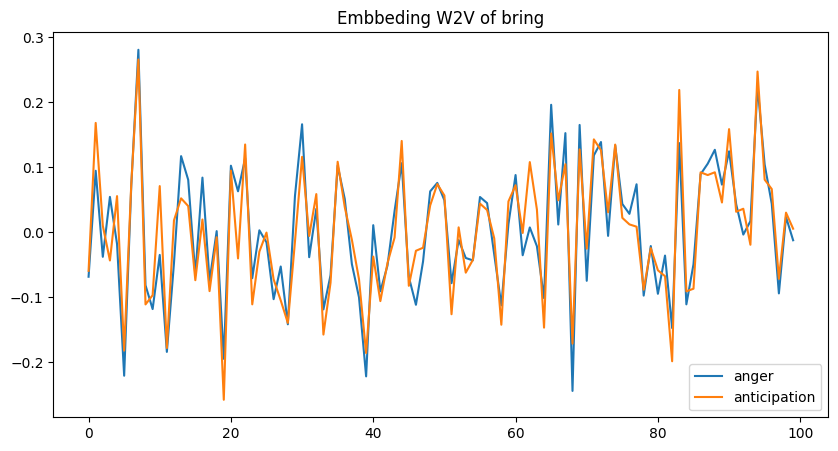

In [11]:
legend = [emotion_a,emotion_b]
plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(word_data["embbeding_model_a"].values[0])
plt.plot(word_data["embbeding_model_b"].values[0])
plt.legend(legend)

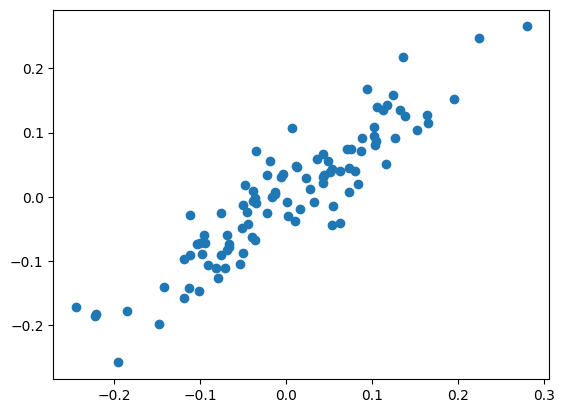

In [12]:
plt.scatter(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0])

In [13]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

display(spearmanr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))
display(pearsonr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))

SignificanceResult(statistic=0.9093309330933094, pvalue=4.209882109466041e-39)

PearsonRResult(statistic=0.9157850532955004, pvalue=1.323292927356247e-40)

In [14]:
set_ = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_fst[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not set_:
        set_ = set_.union(intersection)
    else:
        set_ = set_.intersection(intersection)

display(len(set_))
display(set_)

677

{'a',
 'about',
 'above',
 'across',
 'act',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'ah',
 'air',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'am',
 'among',
 'amp',
 'an',
 'ancient',
 'and',
 'angels',
 'another',
 'answer',
 'any',
 'are',
 'arms',
 'around',
 'as',
 'ask',
 'at',
 'away',
 'b',
 'back',
 'bare',
 'be',
 'bear',
 'beauty',
 'because',
 'become',
 'bed',
 'been',
 'before',
 'begin',
 'behind',
 'behold',
 'being',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'between',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'both',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'but',
 'by',
 'call',
 'called',
 'came',
 'can',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'c

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
set_ = set_ - stop_words
set_

{'across',
 'act',
 'age',
 'ago',
 'ah',
 'air',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'among',
 'amp',
 'ancient',
 'angels',
 'another',
 'answer',
 'arms',
 'around',
 'ask',
 'away',
 'b',
 'back',
 'bare',
 'bear',
 'beauty',
 'become',
 'bed',
 'begin',
 'behind',
 'behold',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'call',
 'called',
 'came',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'clouds',
 'cold',
 'color',
 'come',
 'comes',
 'cool',
 'could',
 'country',
 'course',
 'cried',
 'cries',
 'cry',
 'cup',
 'cut',
 'dark',
 'day',
 'days',
 'dead',
 'dear',
 'death',
 'deep',
 'died',
 'dim',

In [16]:
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

In [17]:
def text_clean(sent):
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [18]:
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)
freq_dict

{'anger': Counter({'the': 5646,
          'and': 3318,
          'of': 2235,
          'a': 1857,
          'to': 1720,
          'in': 1642,
          'i': 1193,
          'that': 872,
          'with': 815,
          'is': 719,
          'his': 688,
          'my': 668,
          'on': 597,
          'for': 596,
          'you': 590,
          'he': 563,
          'it': 557,
          'not': 549,
          'but': 513,
          'words': 481,
          'all': 476,
          'as': 443,
          'at': 410,
          'from': 397,
          'was': 394,
          'me': 383,
          'they': 381,
          'their': 356,
          'by': 349,
          'like': 342,
          'are': 338,
          'your': 336,
          'or': 330,
          'be': 323,
          'her': 323,
          'we': 310,
          'so': 304,
          'this': 290,
          'when': 286,
          'an': 283,
          'no': 268,
          'what': 257,
          'have': 249,
          'will': 232,
          'one': 227,
 

In [19]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations

emotion_combinations = list(combinations(emotion_list,2))

words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_w2v[emotion_a].wv.get_vector(word,norm=True),poems_w2v[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_w2v_info = pd.DataFrame(words_embbed_info)
words_embbed_w2v_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,done,37,128,17,55,89,96,9,149,"(0.898679760722635, 7.478837810197784e-37)",...,"(0.8578595658946727, 4.315722012799016e-30)","(0.8347385196848779, 3.866727511416902e-27)","(0.8550395619382095, 1.0523989616736337e-29)","(0.8128239672363123, 9.833479812814961e-25)","(0.8479906558805739, 9.017375330753069e-29)","(0.8453140938699701, 1.9815906541602575e-28)","(0.830615292461234, 1.1640757844237868e-26)","(0.8228519998801607, 8.573245436146299e-26)","(0.8338687555027525, 4.890997479392201e-27)","(0.8206000135015461, 1.502505143741886e-25)"
1,course,9,30,6,22,37,31,7,59,"(0.8909369418812534, 2.2784109426297983e-35)",...,"(0.8641909881142019, 5.428499925413953e-31)","(0.8900878557814886, 3.262200185415265e-35)","(0.8881021858373281, 7.466347318929848e-35)","(0.8839896085823221, 3.9514805399937365e-34)","(0.8784771617096065, 3.3491957171657745e-33)","(0.8765648558257284, 6.862041072024479e-33)","(0.8816238680662931, 1.001730267695509e-33)","(0.910345407881652, 2.4868943530452202e-39)","(0.8995605242259764, 4.983009457717185e-37)","(0.8895925221414102, 4.0165786851056253e-35)"
2,king,28,72,26,72,109,65,7,234,"(0.9100241970305021, 2.939915824364542e-39)",...,"(0.8631829225832175, 7.603911833164694e-31)","(0.8872225375161242, 1.0721268970259414e-34)","(0.877228138757409, 5.357894399682353e-33)","(0.8880262205104613, 7.704246744369353e-35)","(0.8915134716848623, 1.782601247858538e-35)","(0.877082286176141, 5.658184815850821e-33)","(0.9047995771774255, 4.1079951648583564e-38)","(0.9043854005316996, 5.03011118112141e-38)","(0.9005037874427717, 3.212297267714379e-37)","(0.8943200155754597, 5.290589566278087e-36)"
3,know,104,389,53,241,414,294,50,499,"(0.8136694225293452, 8.05104216839334e-25)",...,"(0.7517693859123915, 2.0143502437013644e-19)","(0.74583285540109, 5.472173592366801e-19)","(0.7988245873203363, 2.344013636934408e-23)","(0.6797457771997635, 7.484028912707769e-15)","(0.6896259655628328, 2.11865962415317e-15)","(0.7013173146232234, 4.453472064469032e-16)","(0.6255086093684287, 3.4641201080845564e-12)","(0.7630659519692149, 2.776513466365308e-20)","(0.7254422056840824, 1.3866437083331088e-17)","(0.7553129209437597, 1.0944461764091197e-19)"
4,everything,11,63,6,35,73,51,13,55,"(0.9072732573453023, 1.201796772974131e-38)",...,"(0.8605826470900066, 1.7916054469612142e-30)","(0.882621307132851, 6.783923047115083e-34)","(0.8781719327738505, 3.758482698406653e-33)","(0.8720367085925758, 3.580263870738742e-32)","(0.8703219797063465, 6.584366759333408e-32)","(0.8628756754291151, 8.421966251562211e-31)","(0.8729547191239274, 2.5744620937707897e-32)","(0.8984325629090126, 8.375986222880396e-37)","(0.8994509252559405, 5.2423245219326715e-37)","(0.8898020906388782, 3.678620558317782e-35)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,drunk,5,14,7,9,12,9,5,11,"(0.9000203260292194, 4.025152327968372e-37)",...,"(0.8536122155544177, 1.6406577957365162e-29)","(0.8906609388510542, 2.5611954906465664e-35)","(0.8621616102591788, 1.0669244934883887e-30)","(0.864681560783917, 4.602887168000719e-31)","(0.8686295174226963, 1.1912739413037307e-31)","(0.8412541153466391, 6.36077589510757e-28)","(0.862635892236813, 9.119506281792731e-31)","(0.878531699182258, 3.280798989430063e-33)","(0.8933733329851907, 8.000124228940317e-36)","(0.865578533416639, 3.398574793612683e-31)"
558,loved,14,79,8,39,160,82,6,76,"(0.8914436127255371, 1.8365399071238837e-35)",...,"(0.8376776594222763, 1.730010621488551e-27)","(0.8208269532683798, 1.4204147901461998e-25)","(0.8682112180119862, 1.3775359285445027e-31)","(0.8666992041802775, 2.3193735520442396e-31)","(0.7646285825749254, 2.09

In [20]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_fst[emotion_a].wv.get_vector(word,norm=True),poems_fst[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_fst_info = pd.DataFrame(words_embbed_info)
words_embbed_fst_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,done,37,128,17,55,89,96,9,149,"(0.8244378955423947, 5.747393374563789e-26)",...,"(0.8233015752583122, 7.657508180420772e-26)","(0.888592466389623, 6.094730628132092e-35)","(0.8631938024504989, 7.576413926776736e-31)","(0.8332700768167016, 5.745153576904393e-27)","(0.7874142778078315, 2.5977626753160693e-22)","(0.6897553905578098, 2.083230083694829e-15)","(0.8069841842182828, 3.809543988422551e-24)","(0.852997863771933, 1.9833054169612404e-29)","(0.8535972447724034, 1.6482752595942509e-29)","(0.7780127317123571, 1.6917183289247874e-21)"
1,course,9,30,6,22,37,31,7,59,"(0.8902244057991421, 3.0798438424776186e-35)",...,"(0.8812761533081485, 1.1465732424724857e-33)","(0.9038185801257138, 6.626590818188646e-38)","(0.8731190029782865, 2.4262614377282615e-32)","(0.8973189226128169, 1.3903836450255095e-36)","(0.8344601716845453, 4.169345368545915e-27)","(0.808510700780708, 2.685812260350808e-24)","(0.8561717637516795, 7.374691997351332e-30)","(0.8930033315288731, 9.393551400267186e-36)","(0.9072947110085983, 1.1888752246447212e-38)","(0.8839001720842745, 4.094415813305023e-34)"
2,king,28,72,26,72,109,65,7,234,"(0.7600789808489096, 4.7387414626147125e-20)",...,"(0.8698381373087126, 7.807197505678707e-32)","(0.8483615527828601, 8.075681063141353e-29)","(0.850920588845302, 3.7424627634550134e-29)","(0.8336164395137096, 5.234711213481918e-27)","(0.8549929930263522, 1.0678358403877465e-29)","(0.7889060777911155, 1.912920317421502e-22)","(0.8381454080024807, 1.519912872281717e-27)","(0.7770159777493667, 2.0524473723478345e-21)","(0.8672954638083057, 1.8900549218725065e-31)","(0.7990120400299756, 2.2503016960817523e-23)"
3,know,104,389,53,241,414,294,50,499,"(0.6660059038629014, 3.997621564913449e-14)",...,"(0.7673953113693427, 1.261462241524595e-20)","(0.8549818015291778, 1.071578460430617e-29)","(0.810014024407772, 1.897796120098083e-24)","(0.7963881362953391, 3.9681101138950244e-23)","(0.7686138098868236, 1.0071722104913308e-20)","(0.5090092249180289, 6.387610163547876e-08)","(0.744487831901962, 6.836472787743812e-19)","(0.744928801362837, 6.356299873499517e-19)","(0.8077072104684135, 3.229564350942439e-24)","(0.648541075342238, 2.973249801081626e-13)"
4,everything,11,63,6,35,73,51,13,55,"(0.8900128509134596, 3.366811263910999e-35)",...,"(0.8774601892639744, 4.9119338523107605e-33)","(0.9040207947151275, 6.007141352734977e-38)","(0.8743476348818758, 1.5531975038830863e-32)","(0.8966046808698177, 1.91854544907119e-36)","(0.8284403434954402, 2.0572960970181e-26)","(0.8095589045825977, 2.1088810636372814e-24)","(0.8649617401876922, 4.1877754654886165e-31)","(0.8902863044176315, 3.0004986213490177e-35)","(0.8913712340117006, 1.8941055103181714e-35)","(0.8815346754827454, 1.0370816273094128e-33)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,drunk,5,14,7,9,12,9,5,11,"(0.8841502424949993, 3.7069001571464907e-34)",...,"(0.8972459234732274, 1.437056604162468e-36)","(0.876187952796069, 7.892970372851969e-33)","(0.8733472595407472, 2.234099379977372e-32)","(0.8935317723773102, 7.467197600532678e-36)","(0.830616466092164, 1.1637155933901203e-26)","(0.8361955019560943, 2.6004875170924107e-27)","(0.8663036701522584, 2.6552449217266363e-31)","(0.8669848510962829, 2.1029901948346894e-31)","(0.9065126258891901, 1.760143134076891e-38)","(0.8868617528255959, 1.2425647342101214e-34)"
558,loved,14,79,8,39,160,82,6,76,"(0.8689688985991995, 1.058435128439858e-31)",...,"(0.7777511299020734, 1.77992383641697e-21)","(0.8914287480668511, 1.8482211102478726e-35)","(0.8750459882557733, 1.2028554743179729e-32)","(0.8489067070141577, 6.863415968677321e-29)","(0.7885893320379

# Modulación de las palabras

In [21]:
#Muestra de la modulación

# Samples per second
sps = 44100

# Duration
duration_s = 5.0

In [22]:
# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 440.0
fm_hz = 220.0
k = 25.0

In [23]:
# First, define our range of sample numbers
each_sample_number = np.arange(duration_s * sps)

# Create the term that create the carrier
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

# Now create the term that is the frequency modulator
modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)

# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + modulator)
waveform_quiet = waveform * 0.3

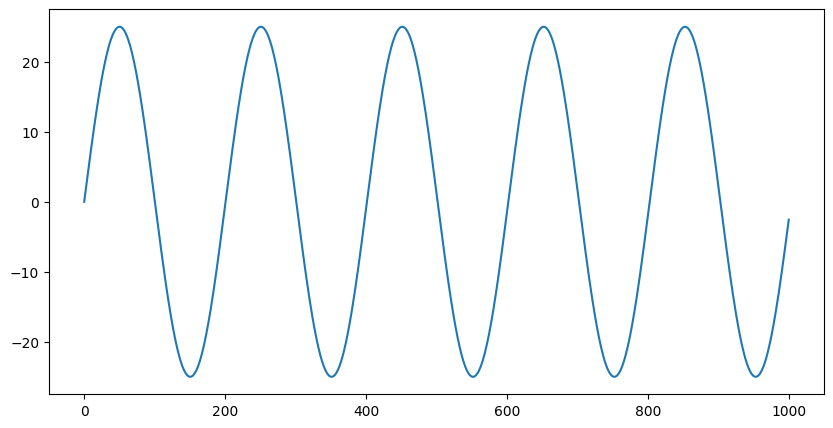

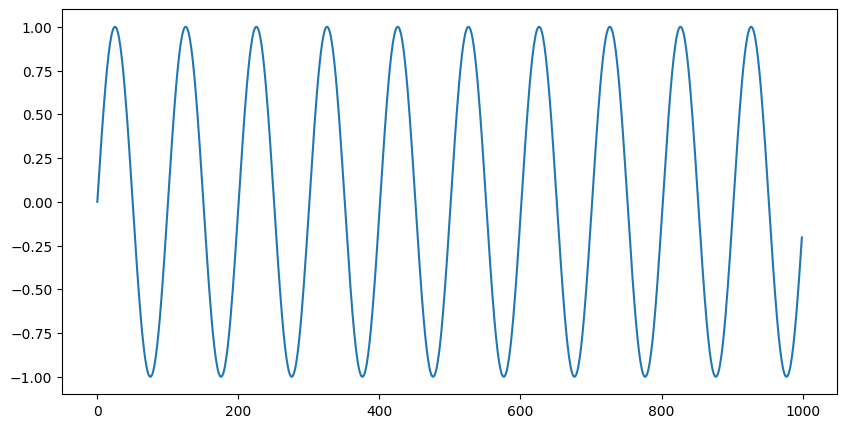

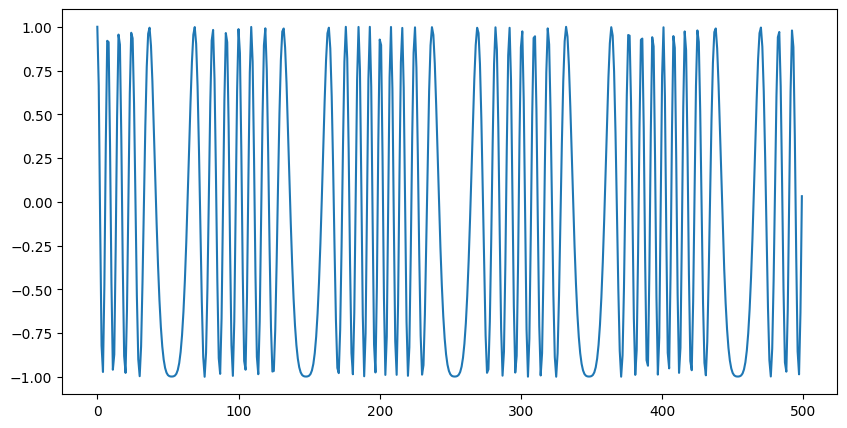

In [25]:
#Graphs
plt.figure(figsize=(10,5))
plt.plot(modulator[:1000])

plt.figure(figsize=(10,5))
plt.plot(np.sin(carrier[:1000]))

plt.figure(figsize=(10,5))
plt.plot(waveform[:500])

Muestra de embbeding modulado.

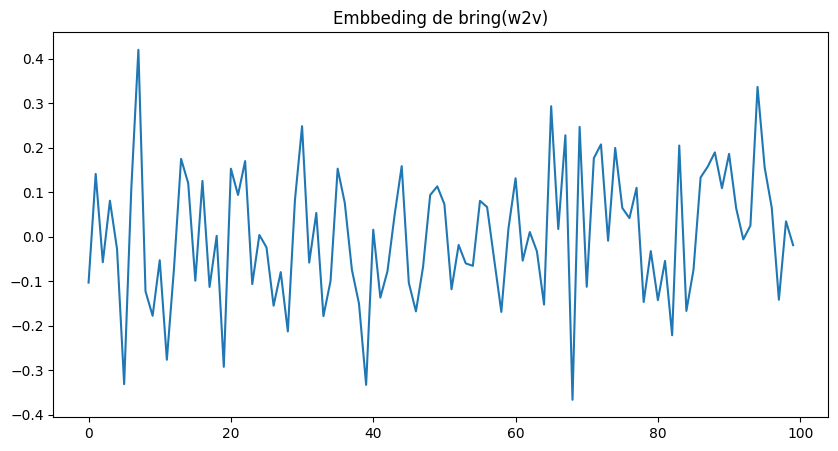

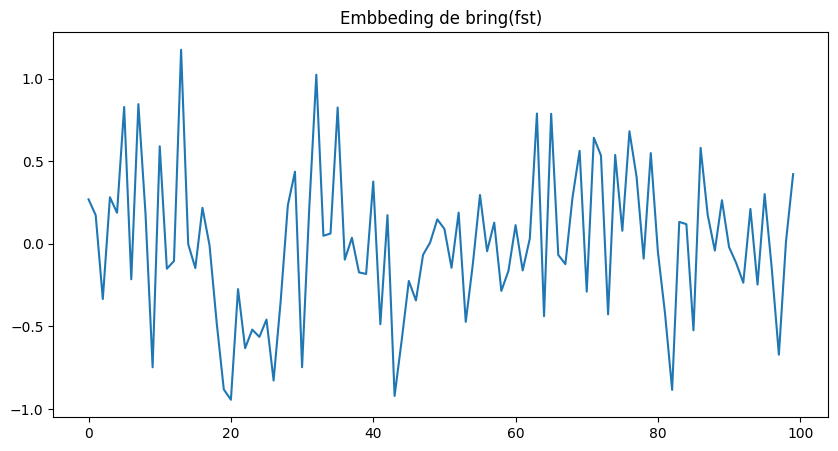

In [26]:
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word)
embbed_fst = poems_fst[emotion].wv.get_vector(word)

plt.figure(figsize=(10,5))
plt.title("Embbeding de "+word+"(w2v)")
plt.plot(embbed_w2v)

plt.figure(figsize=(10,5))
plt.title("Embbeding de "+word+"(fst)")
plt.plot(embbed_fst)

In [45]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 3.0
fm_hz = 50.0
k = 50


each_sample_number = np.arange(duration_s * sps)

carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

#modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)
modulator = embbed_w2v
# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + k*modulator)

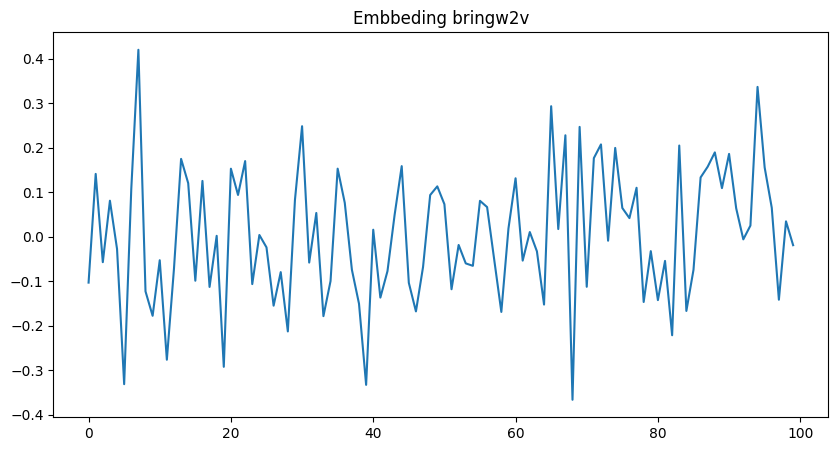

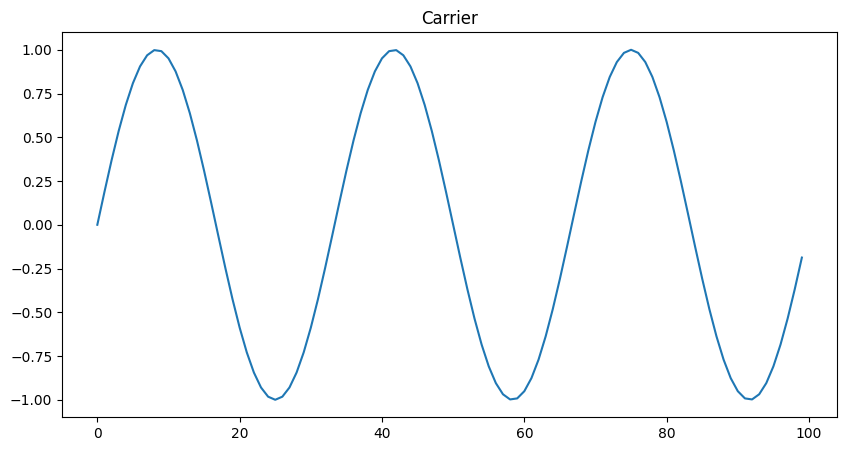

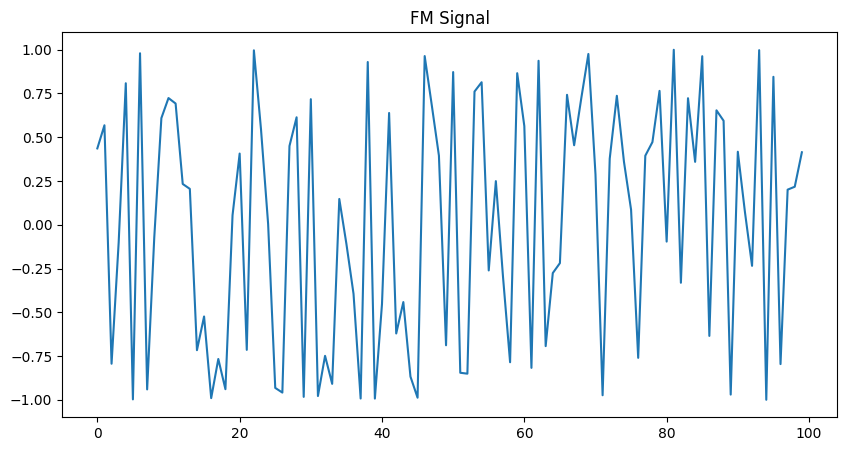

In [47]:
plt.figure(figsize=(10,5))
plt.title("Embbeding "+ word + " w2v")
plt.plot(embbed_w2v)

plt.figure(figsize=(10,5))
plt.title("Carrier")
plt.plot(np.sin(carrier))

plt.figure(figsize=(10,5))
plt.title("FM Signal")
plt.plot(waveform)

# Prueba de separación e impacto en la semántica.

In [48]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant

# Samples per second
sps = 100

# Duration
duration_s = 1.0

carrier_hz_a = 2
carrier_hz_b = 5
k = 50

words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_fst[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_fst[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

words_embbed_fst_mod = pd.DataFrame(words_embbed_info)
words_embbed_fst_mod

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,done,37,128,17,55,89,96,9,149,"(0.009576681066235845, 0.9246603984079363)",...,"(0.06566067807492697, 0.5163044045981059)","(0.1767398353060932, 0.0785684193149902)","(-0.12497500523810876, 0.21538204847512785)","(0.04286657259587714, 0.6719515946291493)","(-0.029151118143271045, 0.7734176582624538)","(0.02677448631531803, 0.7914516424773873)","(-0.06695917283105805, 0.5080245824247802)","(0.15802262318037033, 0.11635879306557045)","(0.08381200319952926, 0.4070801911798772)","(-0.012526111922869577, 0.9015598473625531)"
1,course,9,30,6,22,37,31,7,59,"(-0.009543569461905644, 0.9249201272061632)",...,"(-0.14269318900947447, 0.15670223943087083)","(0.015488721870782311, 0.8784384456970868)","(-0.1153361415424942, 0.25317195723847785)","(0.044634373702379146, 0.6592477766719907)","(-0.057056861747971005, 0.5728529492818623)","(-0.0329132203321516, 0.7451187927582397)","(-0.045097399647840736, 0.6559361164081366)","(0.08964717074866974, 0.3750850800253271)","(-0.1357527310796228, 0.17807585068861614)","(0.06544232872363828, 0.517703438504424)"
2,king,28,72,26,72,109,65,7,234,"(0.00531653203546534, 0.9581324753632802)",...,"(-0.10301361368691238, 0.3077753631204108)","(0.06033190314530894, 0.5509899451540092)","(0.008019812875984429, 0.9368806218077543)","(-0.038291669023911803, 0.7052513852123539)","(0.1911577269549811, 0.05676029983823568)","(0.09595431905545444, 0.34227845852073985)","(0.0573703158638175, 0.5707430121021375)","(-0.01584997320672121, 0.8756256673057087)","(0.27451731717959, 0.005710266001814109)","(0.07003979768092222, 0.4886589891118828)"
3,know,104,389,53,241,414,294,50,499,"(0.012580458304861392, 0.9011349044794938)",...,"(0.15355391541639124, 0.12718555678089624)","(0.11267898881186145, 0.26434408973476325)","(0.20228290575493288, 0.04355866385647542)","(0.08765876216841317, 0.38581174768933474)","(-0.04360686126892119, 0.6666202222022324)","(-0.03165293774750877, 0.7545631749925346)","(-0.27341517030659274, 0.005915480031064285)","(0.11026805090238916, 0.27476651793041834)","(0.08673532960774674, 0.3908553916237354)","(-0.1756622944005178, 0.08043659327398271)"
4,everything,11,63,6,35,73,51,13,55,"(0.007258931054720468, 0.9428584690979468)",...,"(-0.014326665694337005, 0.8874965372188736)","(0.0314833953114638, 0.7558364993359505)","(-0.10803720687576931, 0.28465334980498086)","(-0.08557570048612184, 0.39724464882285976)","(0.020472645064400937, 0.8397809278061659)","(-0.06837209143721948, 0.49909370123795815)","(0.04678871862028718, 0.6438963249100019)","(0.04456645685642715, 0.6597340879695679)","(-0.1604997381633521, 0.11067233152963858)","(-0.12142288915582053, 0.22881323485275262)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,drunk,5,14,7,9,12,9,5,11,"(-0.05926448896330121, 0.5580710523344284)",...,"(-0.09591146140344249, 0.3424950971335937)","(-0.03990655528902749, 0.6934293958439465)","(-0.10026977405658823, 0.3209070764432274)","(-0.0034151869380915807, 0.973098365694608)","(-0.06840626795390284, 0.4988786978706926)","(0.01652155417225411, 0.8704007325156848)","(-0.010569108056189415, 0.9168795514459017)","(0.03423077515214081, 0.7352854149055175)","(-0.09218111702533949, 0.3616814350967075)","(-0.010413931087142201, 0.9180956751292765)"
558,loved,14,79,8,39,160,82,6,76,"(-0.05432409236711442, 0.591400463848799)",...,"(-0.13050708761613852, 0.1955943343318653)","(0.16722446961799423, 0.09632200961669699)","(-0.10558438961175541, 0.29579424758612266)","(0.07778333188511258, 0.44176244586911195)","(-0.07041209731814978, 0.48634545012676444)","(-0.036793995206034505, 0.7162783622401844)","(0.01615841370534887

In [50]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

words_embbed_w2v_mod = pd.DataFrame(words_embbed_info)
words_embbed_w2v_mod

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,done,37,128,17,55,89,96,9,149,"(0.08907321334092175, 0.37816255902843643)",...,"(-0.024669320033885514, 0.807518379970634)","(0.015751381315521916, 0.8763931724237953)","(0.0965100990087107, 0.33947689746976295)","(0.135142706751326, 0.18005189295556326)","(0.0137834684242267, 0.8917357366215213)","(-0.22316817246639203, 0.025624794018346365)","(-0.1329606750873878, 0.18725141472209944)","(-0.03385386653092318, 0.7380941378743918)","(-0.16538047485374485, 0.10010261325875666)","(0.04369517181675325, 0.6659853308057814)"
1,course,9,30,6,22,37,31,7,59,"(-0.002623828004835532, 0.979330367676745)",...,"(-0.003538341078101432, 0.97212865490748)","(0.0864804873990722, 0.39225421139879724)","(0.008399009058827506, 0.9339027638902251)","(-0.04354729297714598, 0.6670486096337277)","(0.12272820066206962, 0.22381099665278775)","(-0.011743611429880188, 0.9076813617460437)","(0.03875319342838919, 0.7018654285114766)","(-0.007154725520680282, 0.9436774112904394)","(-0.08873653173252605, 0.37997490245544047)","(-0.15118761002255823, 0.13322281796611551)"
2,king,28,72,26,72,109,65,7,234,"(-0.037185908193728384, 0.7133870682331094)",...,"(0.019210132673610034, 0.849541378433977)","(0.07378219200714932, 0.4656708813893498)","(0.024976461877027668, 0.8051690976484339)","(0.14431223851764274, 0.15200391442712205)","(0.09257178413729475, 0.3596415763624911)","(-0.11058032876870232, 0.27340119105219324)","(-0.06250212871014876, 0.5367285021101081)","(-0.06314630276950484, 0.5325308352636119)","(-0.052788352963360125, 0.6019414566471295)","(-0.1554687658386883, 0.12245539410011239)"
3,know,104,389,53,241,414,294,50,499,"(0.09179129097240511, 0.3637240042452304)",...,"(-0.11696775885278281, 0.24647450651731936)","(-0.01185909138820855, 0.9067776116901588)","(0.0051539110647403266, 0.9594120050855238)","(0.08189774469749155, 0.41791553838998335)","(-0.001999543436574251, 0.9842475436142566)","(-0.07531975546228054, 0.456400587436792)","(0.017961223659060662, 0.8592190600755386)","(0.005281261634775601, 0.9584099800251908)","(0.0908526987341531, 0.3686710077532078)","(-0.1491495871670818, 0.13859546586716606)"
4,everything,11,63,6,35,73,51,13,55,"(0.1258312654278613, 0.21222979308475529)",...,"(-0.15976558897101423, 0.11233463980146474)","(0.06381035908575838, 0.5282208032530862)","(0.030128340200977113, 0.7660366566301067)","(0.1431950367275677, 0.15523447552392783)","(0.029580157783765784, 0.7701745748087735)","(0.02621597372585035, 0.7957060453904219)","(-0.07903042764301811, 0.434454525039137)","(-0.11791921251047141, 0.24262591490634666)","(0.016938195974281964, 0.8671620203178512)","(-0.15228570697097704, 0.13039458491625208)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,drunk,5,14,7,9,12,9,5,11,"(-0.03759916523207994, 0.7103426961840459)",...,"(-0.05371187515933267, 0.5955925822396917)","(0.03184091047749062, 0.7531522000954101)","(-0.04624486752001892, 0.6477579386910224)","(0.050867007135588574, 0.6152452547535661)","(0.029687255020273865, 0.7693656479453244)","(0.10624866052417414, 0.292749085192837)","(-0.016077424131899852, 0.8738554778679438)","(-0.09346183479905087, 0.35502083666736983)","(0.0945468013919199, 0.34943833159186477)","(-0.027530439197156538, 0.7857030117013871)"
558,loved,14,79,8,39,160,82,6,76,"(0.10046039432452711, 0.3199833076629085)",...,"(-0.12504600094506083, 0.21511942754748895)","(0.1450998311416858, 0.14975693951862515)","(0.22327317838537286, 0.025553643564795468)","(0.11805504415318202, 0.2420798942659713)","(0.08815435390171525, 0.3831211194232541)","(-0.08393316125864853, 0.40639999393766035)","(0.006457802887431537,

In [56]:
#Información de correlacion datos modulados.
pearsonr_mod_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_mod_data_w2v[comb] = [data[0] for data in words_embbed_w2v_mod["P_"+str(comb)]]

pearsonr_mod_data_fst = {}

for comb in emotion_combinations:
    pearsonr_mod_data_fst[comb] = [data[0] for data in words_embbed_fst_mod["P_"+str(comb)]]

#Información de correlacion datos no modulados.
pearsonr_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_w2v_info["P_"+str(comb)]]

pearsonr_data_fst = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_fst_info["P_"+str(comb)]]


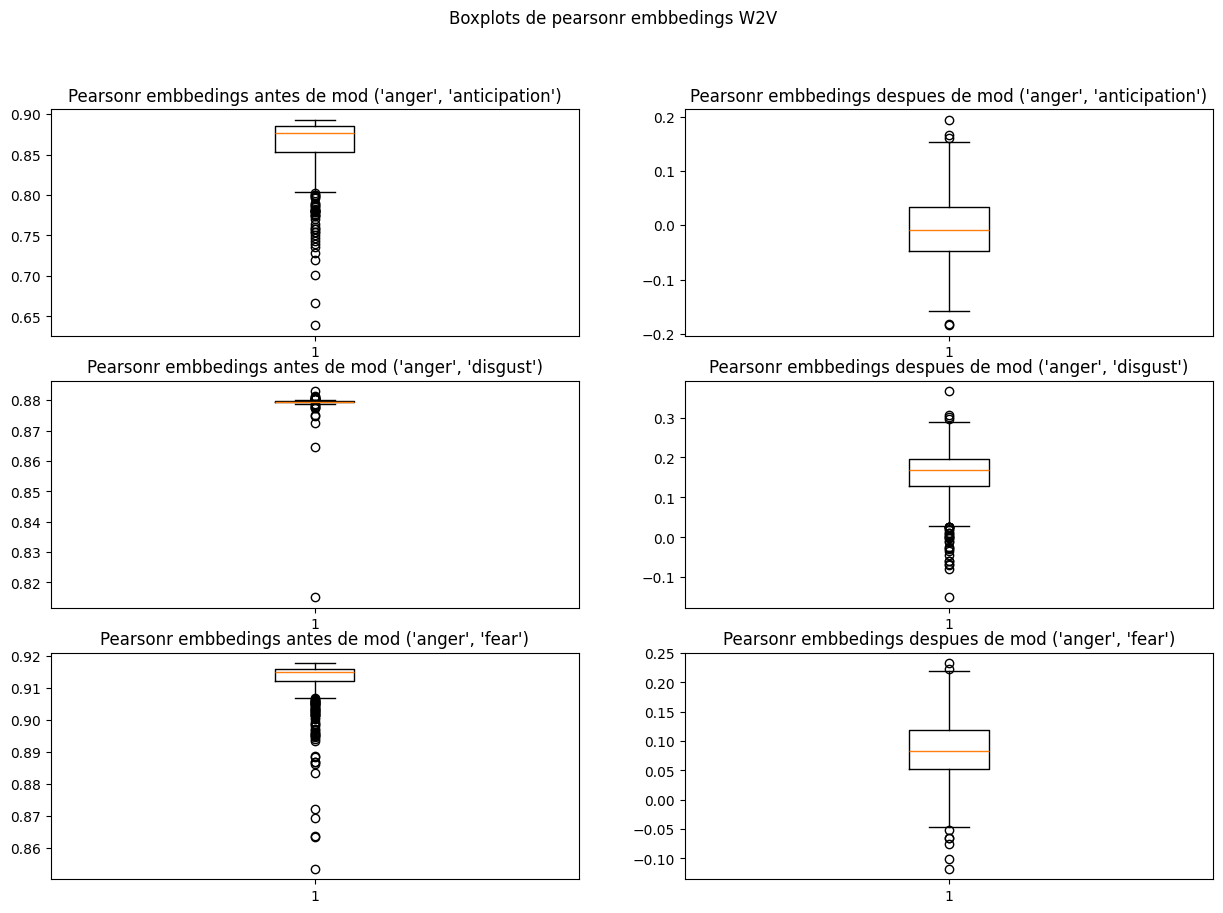

In [64]:
fig,ax = plt.subplots(3,2,figsize=(15,10))

fig.suptitle("Boxplots de pearsonr embbedings W2V")
for i in range(3):
    comb = emotion_combinations[i]
    ax[i,0].set_title("Pearsonr embbedings antes de mod "+str(comb))
    ax[i,0].boxplot(pearsonr_data_w2v[comb])

    ax[i,1].set_title("Pearsonr embbedings despues de mod "+str(comb))
    ax[i,1].boxplot(pearsonr_mod_data_w2v[comb])
plt.show()

In [ ]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_fst[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_fst[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        np.norm

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

words_embbed_fst_mod = pd.DataFrame(words_embbed_info)
words_embbed_fst_mod